# Pipelines and Hyperparameter Tuning


### Context
The original dataset contains 1000 entries with 20 categorical/symbolic attributes prepared by Prof. Hofmann. In this dataset, each entry represents a person who takes a credit by a bank. Each person is classified as good or bad credit risks according to the set of attributes. It is almost impossible to understand the original dataset due to its complicated system of categories and symbols. Thus, the attributes in this dataset is a subset of the original dataset. Several columns are simply ignored, and some of the important attributes like age, account balance etc. are retained.

### Objective 
The objective is to build a model to predict whether a person would default or not. In this dataset, the target variable is 'Risk'.

### Dataset:
- Age (Numeric : Age in years)
- Sex (Categories : male, female)
- Job (Categories : 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
- Housing (Categories : own, rent, or free)
- Saving accounts (Categories : little, moderate, quite rich, rich)
- Checking account (Categories : little, moderate, rich)
- Credit amount (Numeric : Amount of credit in DM - Deutsche Mark)
- Duration (Numeric : Duration for which the credit is given in months)
- Purpose (Categories: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)
- Risk (0 - Person is not at risk, 1 - Pesron is at risk(defaulter))

## Let's start by importing necessary libraries

In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn import metrics


from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    RandomForestClassifier,
)
from xgboost import XGBClassifier

## Load and overview the dataset

In [2]:
# Loading the dataset - sheet_name parameter is used if there are multiple tabs in the excel file.
data = pd.read_csv("German_Credit.csv")

In [3]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,0
1,22,female,2,own,little,moderate,5951,48,radio/TV,1
2,49,male,1,own,little,NaN,2096,12,education,0
3,45,male,2,free,little,little,7882,42,furniture/equipment,0
4,53,male,2,free,little,little,4870,24,car,1


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Age               1000 non-null   int64 
 1   Sex               1000 non-null   object
 2   Job               1000 non-null   int64 
 3   Housing           1000 non-null   object
 4   Saving accounts   817 non-null    object
 5   Checking account  606 non-null    object
 6   Credit amount     1000 non-null   int64 
 7   Duration          1000 non-null   int64 
 8   Purpose           1000 non-null   object
 9   Risk              1000 non-null   int64 
dtypes: int64(5), object(5)
memory usage: 78.2+ KB


- There are total 10 columns and 1,000 observations in the dataset
- We can see that 2 columns have less than 1,000 non-null values i.e. columns have missing values.

**Check the percentage of missing values in each column and impute them**

In [5]:
pd.DataFrame(
    data={
        "% of Missing Values": round(data.isna().sum() / data.isna().count() * 100, 2)
    }
)

,% of Missing Values
Age,0.0
Sex,0.0
Job,0.0
Housing,0.0
Saving accounts,18.3
Checking account,39.4
Credit amount,0.0
Duration,0.0
Purpose,0.0
Risk,0.0


- `Saving accounts` column has 18.3% missing values out of the total observations.
- `Checking account` column has 39.4% missing values out of the total observations.
-  We will impute these values after splitting the data into train and test sets.

In [6]:
#Checking that there is no null value in the dataset
data.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
Risk                  0
dtype: int64

**Let's check the number of unique values in each column**

In [7]:
data.nunique()

Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
Risk                  2
dtype: int64

- Age has only 53 unique values i.e. most of the customers are of similar age
- We have only three continuous variables - Age, Credit Amount and Duration.
- All other variables are categorical

**Checking the value count for each category of categorical variables** 

In [8]:
# Making a list of all catrgorical variables
cat_col = [
    "Sex",
    "Job",
    "Housing",
    "Saving accounts",
    "Checking account",
    "Purpose",
    "Risk",
]

# Printing number of count of each unique value in each column
for column in cat_col:
    print(data[column].value_counts())
    print("-" * 40)

male      690
female    310
Name: Sex, dtype: int64
----------------------------------------
2    630
1    200
3    148
0     22
Name: Job, dtype: int64
----------------------------------------
own     713
rent    179
free    108
Name: Housing, dtype: int64
----------------------------------------
little        603
moderate      103
quite rich     63
rich           48
Name: Saving accounts, dtype: int64
----------------------------------------
little      274
moderate    269
rich         63
Name: Checking account, dtype: int64
----------------------------------------
car                    337
radio/TV               280
furniture/equipment    181
business                97
education               59
repairs                 22
vacation/others         12
domestic appliances     12
Name: Purpose, dtype: int64
----------------------------------------
0    700
1    300
Name: Risk, dtype: int64
----------------------------------------


- We have more male customers as compared to female customers
- There are very few observations i.e. only 22 for customers with job category - unskilled and non-resident
- We can see that the distribution of classes in the target variable is imbalanced i.e. only 30% observations with defaulters.

**Summary of the data**

In [9]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0
Risk,1000.0,0.300,0.458487,0.0,0.0,0.0,1.00,1.0


- Mean value for the age column is approx 35 and median is 33. This shows that majority of the customers are under 35 years of age.
- Mean amount of credit is approx 3,271 but it has a wide range with from 250 to 18,424. We will explore this further in univariate analysis.
- Mean duration for which the credit is given is approx 21 months.

## Univariate analysis

In [10]:
# While doing uni-variate analysis of numerical variables we want to study their central tendency
# and dispersion.
# Let us write a function that will help us create boxplot and histogram for any input numerical
# variable.
# This function takes the numerical column as the input and returns the boxplots
# and histograms for the variable.
# Let us see if this help us write faster and cleaner code.
def histogram_boxplot(feature, figsize=(15, 10), bins=None):
    """Boxplot and histogram combined
    feature: 1-d feature array
    figsize: size of fig (default (9,8))
    bins: number of bins (default None / auto)
    """
    f2, (ax_box2, ax_hist2) = plt.subplots(
        nrows=2,  # Number of rows of the subplot grid= 2
        sharex=True,  # x-axis will be shared among all subplots
        gridspec_kw={"height_ratios": (0.25, 0.75)},
        figsize=figsize,
    )  # creating the 2 subplots
    sns.boxplot(
        feature, ax=ax_box2, showmeans=True, color="violet"
    )  # boxplot will be created and a star will indicate the mean value of the column
    sns.distplot(
        feature, kde=F, ax=ax_hist2, bins=bins, color="orange"
    ) if bins else sns.distplot(
        feature, kde=False, ax=ax_hist2, color="tab:cyan"
    )  # For histogram
    ax_hist2.axvline(
        np.mean(feature), color="purple", linestyle="--"
    )  # Add mean to the histogram
    ax_hist2.axvline(
        np.median(feature), color="black", linestyle="-"
    )  # Add median to the histogram

### Observation on Age 

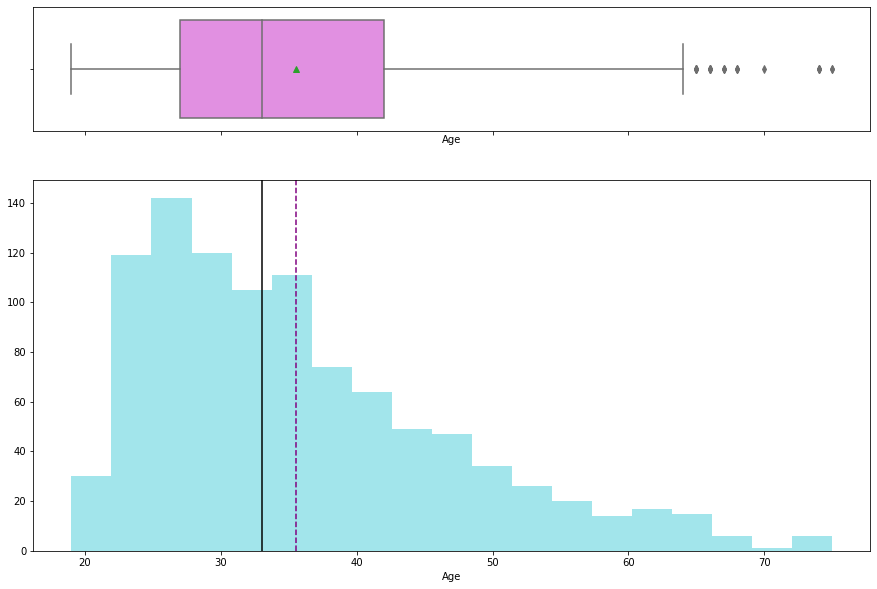

In [11]:
histogram_boxplot(data["Age"])

- The distribution of age is right skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

### Observation on Credit Amount

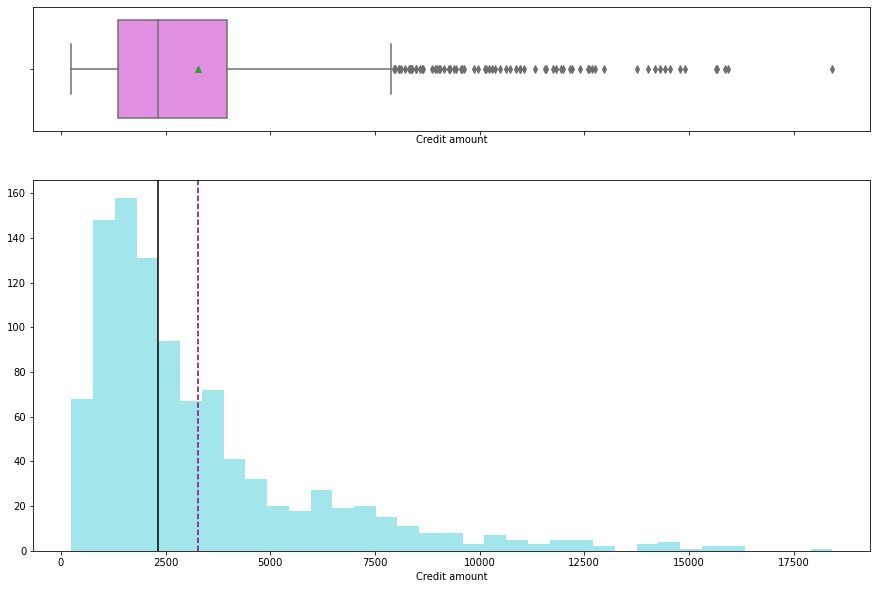

In [12]:
histogram_boxplot(data["Credit amount"])

- The distribution of the credit amount is right skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

### Observations on Duration

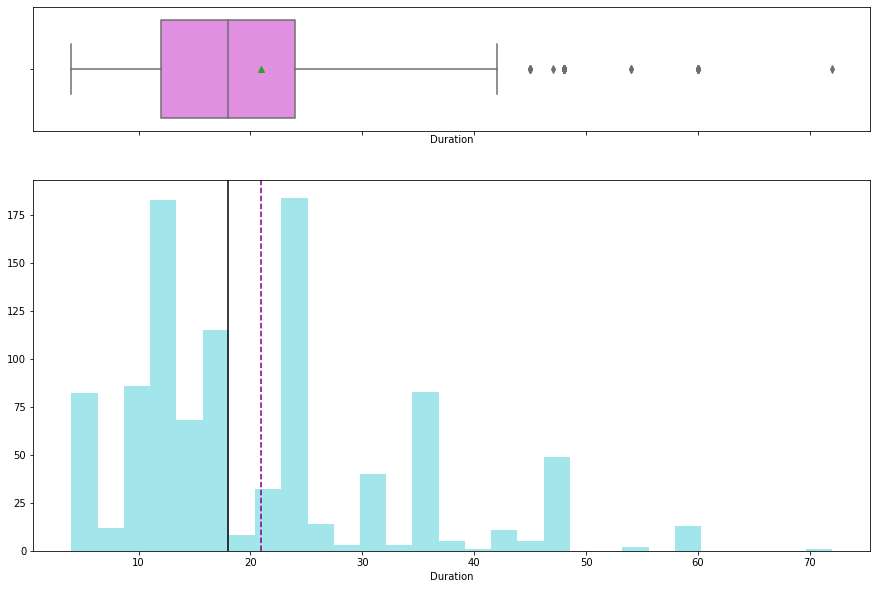

In [13]:
histogram_boxplot(data["Duration"])

- The distribution of the duration for which the credit is given is right skewed
- The boxplot shows that there are outliers at the right end
- We will not treat these outliers as they represent the real market trend

In [14]:
# Function to create barplots that indicate percentage for each category.


def perc_on_bar(plot, feature):
    """
    plot
    feature: categorical feature
    the function won't work if a column is passed in hue parameter
    """
    total = len(feature)  # length of the column
    for p in ax.patches:
        percentage = "{:.1f}%".format(
            100 * p.get_height() / total
        )  # percentage of each class of the category
        x = p.get_x() + p.get_width() / 2 - 0.05  # width of the plot
        y = p.get_y() + p.get_height()  # hieght of the plot
        ax.annotate(percentage, (x, y), size=12)  # annotate the percantage
    plt.show()  # show the plot

### Observations on Risk

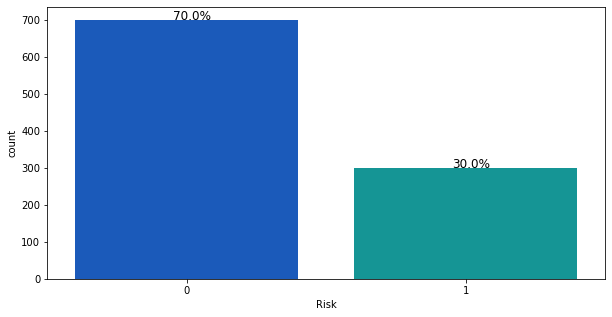

In [15]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Risk"], palette="winter")
perc_on_bar(ax, data["Risk"])

- As mentioned earlier, the class distribution in the target variable is imbalanced.
- We have 70% observations for non-defaulters and 30% observations for defaulters.

### Observations on Sex of Customers

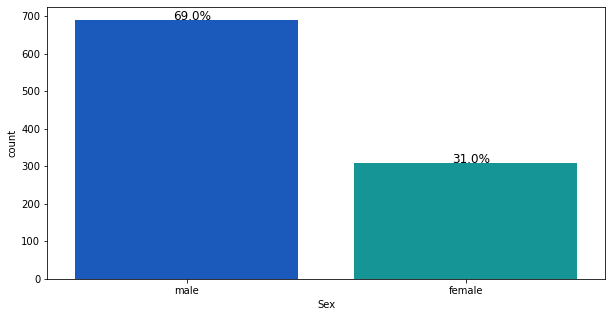

In [16]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Sex"], palette="winter")
perc_on_bar(ax, data["Sex"])

- Male customers are taking more credit than female customers
- There are approx 69% male customers and  to the female customers

### Observations on Housing

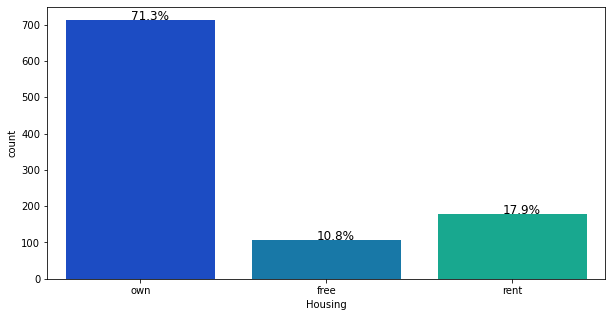

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Housing"], palette="winter")
perc_on_bar(ax, data["Housing"])

- Major of the customers, approx 71%, who take credit have there own house
- Approx 18% customers are living in a rented house
- There are only 11% customers who have a free housing. These are the customers who live in a house given by their company or organization

### Observations on Job

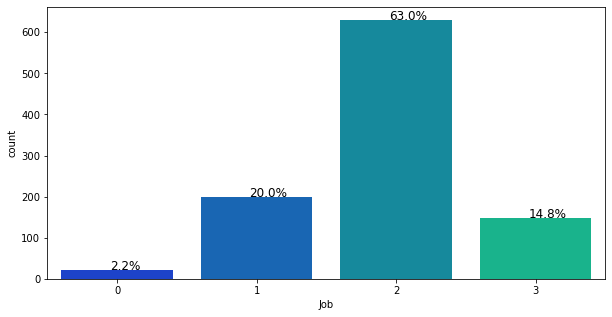

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Job"], palette="winter")
perc_on_bar(ax, data["Job"])

- Majority of the customers i.e. 63% fall into the skilled category.
- There are only approx 15% customers that lie in highly skilled category which makes sense as these may be the persons with high education or highly experienced.
- There are a very few observations, approx 22%, with 0 or 1 job category.

### Observations on Saving accounts

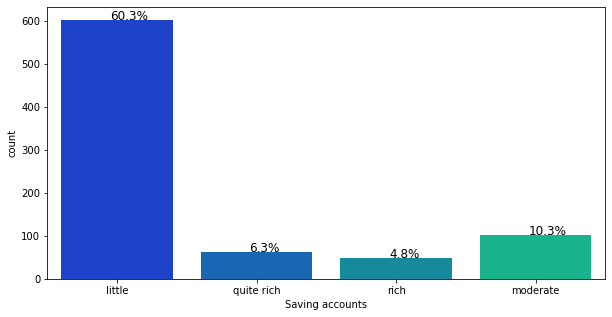

In [19]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Saving accounts"], palette="winter")
perc_on_bar(ax, data["Saving accounts"])

- Approx 70% customers who take credit have little or moderate amount in their savings account. This makes sense as these customers would need credit more than the other categories.
- Approx 11% customers who take credit are in rich category based on their balance in savings account.
- Note that the percentages do no add up to 100 as we have missing values in this column.

### Observations on Checking account

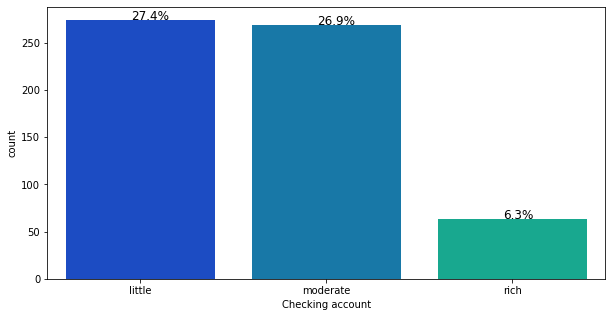

In [20]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data["Checking account"], palette="winter")
perc_on_bar(ax, data["Checking account"])

- Approx 54% customers who take credit have little or moderate amount in their checking account. This makes sense as these customers would need credit more than the other categories.
- Approx 6% customers who take credit are in rich category based on their balance in checking account.
- Note that the percentages do no add up to 100 as we have missing values in this column.

### Observations on Purpose

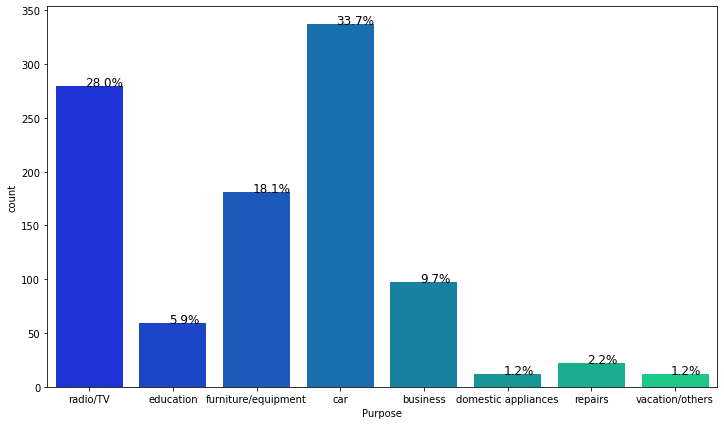

In [21]:
plt.figure(figsize=(12, 7))
ax = sns.countplot(data["Purpose"], palette="winter")
perc_on_bar(ax, data["Purpose"])

- The plot shows that most customers takes credit for luxury items like car, radio or furniture/equipment, domestic appliances.
- Approximately just 16% customers takes credit for business or education

## Bivariate Analysis

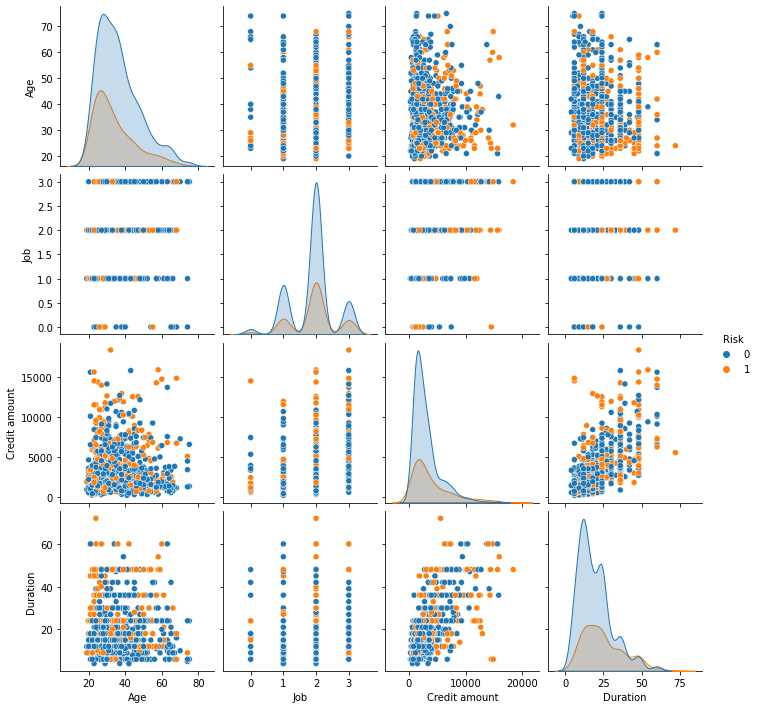

In [22]:
sns.pairplot(data, hue="Risk")

- There are overlaps i.e. no clear distinction in the distribution of variables for people who have defaulted and did not default.
- Let's explore this further with the help of other plots.

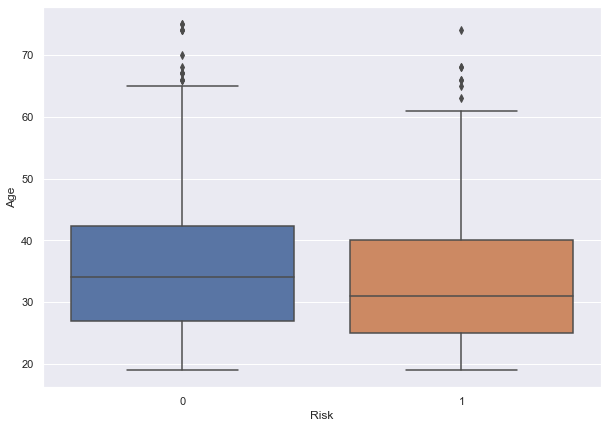

In [23]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Age", data=data, orient="vertical")

- We can see that median age of defaulters is less than median age of non-defaulters.
- This shows that younger customers are more likely to default.
- There are outliers in boxplots of both class distributions

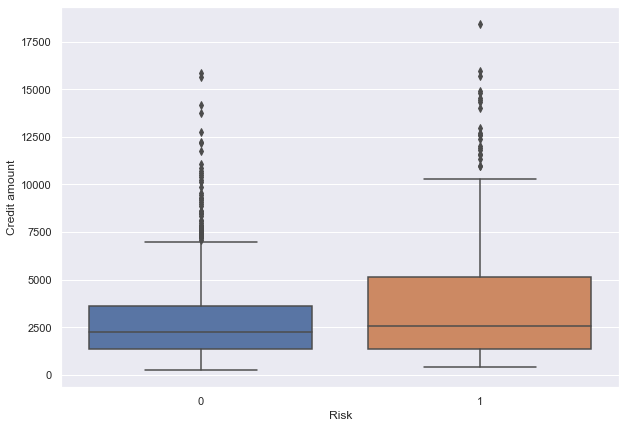

In [24]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Credit amount", data=data, orient="vertical")

- We can see that third quartile amount of defaulters is much more than the third quartile amount of non-defaulters.
- This shows that customers with high credit amount are more likely to default.
- There are outliers in boxplots of both class distributions

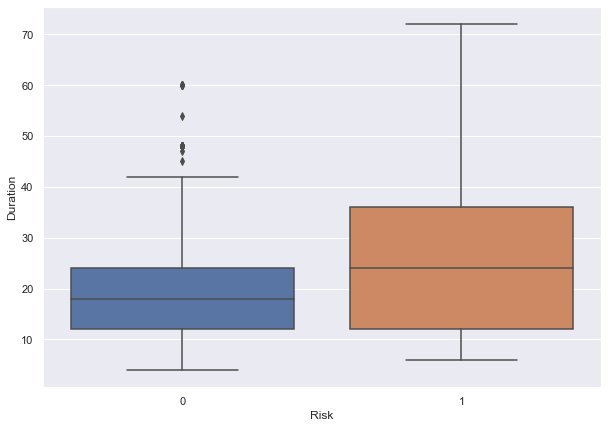

In [25]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Risk", y="Duration", data=data, orient="vertical")

- We can see that second and third quartile duration of defaulters is much more than the second and third quartile duration of non-defaulters.
- This shows that customers with high duration are more likely to default.

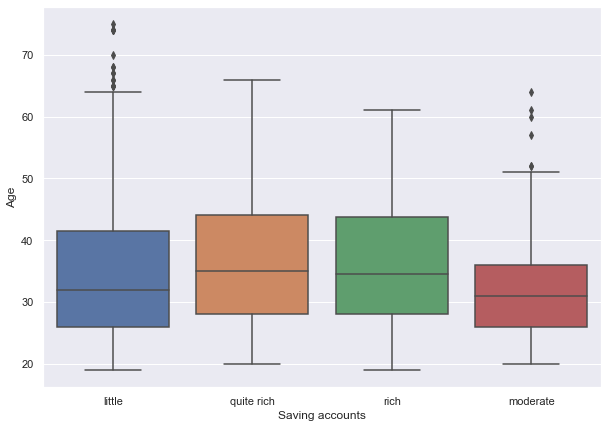

In [26]:
sns.set(rc={"figure.figsize": (10, 7)})
sns.boxplot(x="Saving accounts", y="Age", data=data)

- The plot shows that customers with higher age are in rich or quite rich category.
- Age of the customers in little and moderate category is slightly less but there are outliers in both of the distributions.

In [27]:
## Function to plot stacked bar chart
def stacked_plot(x):
    sns.set(palette="nipy_spectral")
    tab1 = pd.crosstab(x, data["Risk"], margins=True)
    print(tab1)
    print("-" * 120)
    tab = pd.crosstab(x, data["Risk"], normalize="index")
    tab.plot(kind="bar", stacked=True, figsize=(10, 5))
    # plt.legend(loc='lower left', frameon=False)
    # plt.legend(loc="upper left", bbox_to_anchor=(0,1))
    plt.show()

Risk      0    1   All
Sex                   
female  201  109   310
male    499  191   690
All     700  300  1000
------------------------------------------------------------------------------------------------------------------------


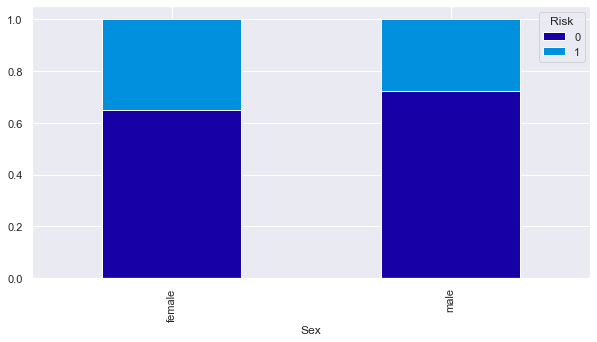

In [28]:
stacked_plot(data["Sex"])

- We saw earlier that the percentage of male customers is more than the female customers. This plot shows that female customers are more likely to default as compared to male customers.

Risk    0    1   All
Job                 
0      15    7    22
1     144   56   200
2     444  186   630
3      97   51   148
All   700  300  1000
------------------------------------------------------------------------------------------------------------------------


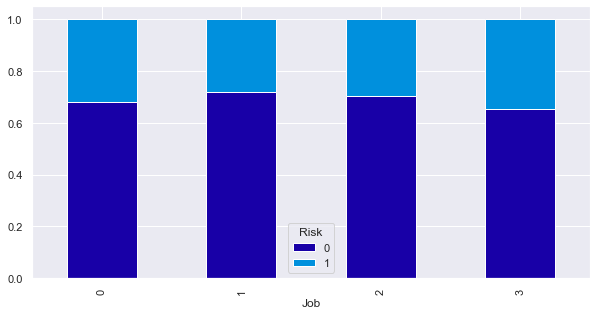

In [29]:
stacked_plot(data["Job"])

- There are no significant difference with respect to the job level
- However, highly skilled or unskilled/non-resident customers are more likely to default as compared to customers in 1 or 2 category 

Risk       0    1   All
Housing                
free      64   44   108
own      527  186   713
rent     109   70   179
All      700  300  1000
------------------------------------------------------------------------------------------------------------------------


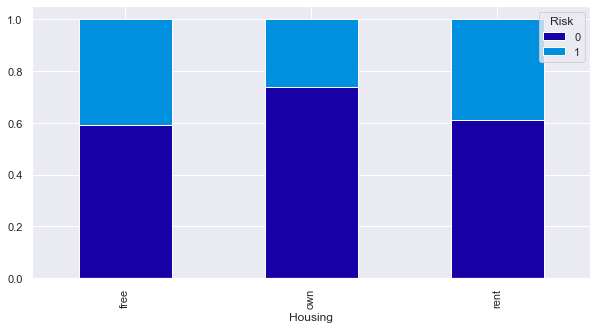

In [30]:
stacked_plot(data['Housing'])

- Customers owning a house are less likely to default
- Customers with free or rented housing are almost at same risk of default

Risk               0    1  All
Saving accounts               
little           386  217  603
moderate          69   34  103
quite rich        52   11   63
rich              42    6   48
All              549  268  817
------------------------------------------------------------------------------------------------------------------------


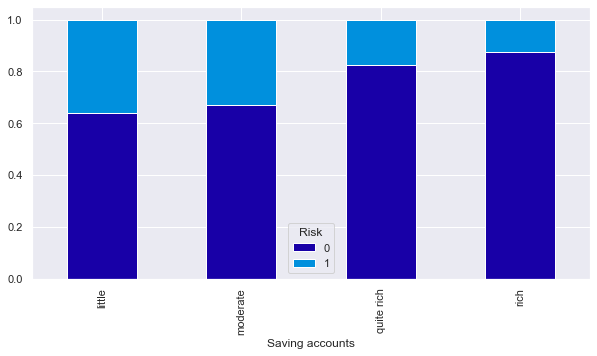

In [31]:
stacked_plot(data["Saving accounts"])

- As we saw earlier, customers with little or moderate amount in saving accounts takes more credit but at the same time they are most likely to default.
- Rich customers are slightly less likely to default as compared to quite rich customers

Risk                0    1  All
Checking account               
little            139  135  274
moderate          164  105  269
rich               49   14   63
All               352  254  606
------------------------------------------------------------------------------------------------------------------------


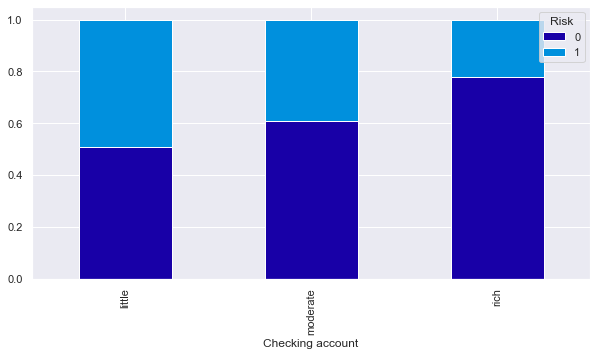

In [32]:
stacked_plot(data['Checking account'])

- The plot further confirms the findings of the plot above.
- Customers with little amount in checking accounts are most likely to default as compared to customers with moderate amount, which in turn, are more likely as compared to the rich customers.

Risk                   0    1   All
Purpose                            
business              63   34    97
car                  231  106   337
domestic appliances    8    4    12
education             36   23    59
furniture/equipment  123   58   181
radio/TV             218   62   280
repairs               14    8    22
vacation/others        7    5    12
All                  700  300  1000
------------------------------------------------------------------------------------------------------------------------


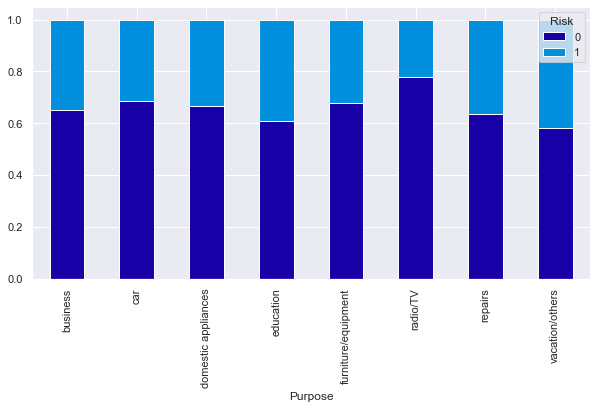

In [33]:
stacked_plot(data["Purpose"])

- Customers who take credit for radio/TV are least likely to default. This might be because their credit amount is small.
- Customers who take credit for education or vacation are most likely to default.
- Other categories have no significant difference between their default and non-default ratio.

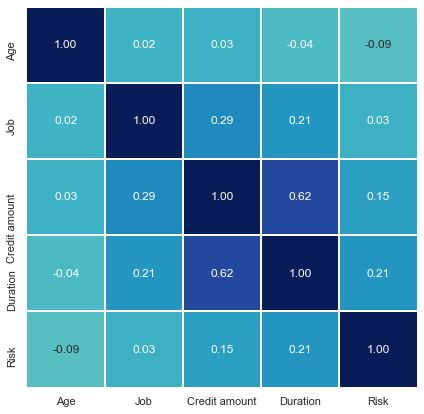

In [34]:
sns.set(rc={"figure.figsize": (7, 7)})
sns.heatmap(
    data.corr(),
    annot=True,
    linewidths=0.5,
    center=0,
    cbar=False,
    cmap="YlGnBu",
    fmt="0.2f",
)
plt.show()

- Credit amount and duration have positive correlation which makes sense as customers might take the credit for longer duration if the amount of credit is high
- Other variables have no significant correlation between them

## Model Building - Approach
1. Partition the data into train and test set.
2. Treat missing values using KNNImputer
3. Built different classifiers using K-Fold cross validation, pipelines and StandardScaler.
4. Hyperparameter tuning the model which gives the best cross validation score 
6. Build the model using optimal hyperparameters and test the performance on the test set.

### Model evaluation criterion

### We will be using Recall as a metric for our model performance, because here company could face 2 types of losses
1. Could Give loan to defaulters - Loss of money
2. Not give Loan to non-defaulters - Loss of opportunity

### Which Loss is greater ? 
* Giving loan to defaulters i.e Predicting a person not at risk, while in actual person is at risk of making a default. 

### How to reduce this loss i.e need to reduce False Negatives ?
* Company wants recall to be maximized i.e. we need reduce the number of false negatives.

### First, let's impute missing values

* We will use KNN imputer to impute missing values.
* `KNNImputer`: Each sample's missing values are imputed by looking at the n_neighbors nearest neighbors found in the training set. Default value for n_neighbors=5.
* KNN imputer replaces missing values using the average of k nearest non-missing feature values.
* Nearest points are found based on euclidean distance.

In [35]:
# Encoding variables - Saving accounts and Checking account.
data["Saving accounts"] = data["Saving accounts"].map(
    {"little": 1, "moderate": 2, "rich": 3, "quite rich": 4}
)

data["Checking account"] = data["Checking account"].map(
    {"little": 1, "moderate": 2, "rich": 3}
)

**NOTE:** We can encode these categories 1,2,and 3 as variables 

In [36]:
data.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,1.0,1169,6,radio/TV,0
1,22,female,2,own,1.0,2.0,5951,48,radio/TV,1
2,49,male,1,own,1.0,NaN,2096,12,education,0
3,45,male,2,free,1.0,1.0,7882,42,furniture/equipment,0
4,53,male,2,free,1.0,1.0,4870,24,car,1


### Split data

In [37]:
X = data.drop(["Risk"], axis=1)
y = data["Risk"]

In [38]:
# Splitting data into training and test set:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y
)
print(X_train.shape, X_test.shape)

(700, 9) (300, 9)


In [39]:
# Creating a list of columns with missing values
reqd_col_for_impute = ["Saving accounts", "Checking account"]

In [40]:
imputer = KNNImputer(n_neighbors=5)

In [41]:
# Fit and transform the train data
X_train[reqd_col_for_impute] = imputer.fit_transform(X_train[reqd_col_for_impute])

# Transform the test data
X_test[reqd_col_for_impute] = imputer.transform(X_test[reqd_col_for_impute])

In [42]:
# As KNNInputer replaces the missing value with the mean of K nearest neighbours, we will roundoff those values
X_train[reqd_col_for_impute] = np.round(X_train[reqd_col_for_impute])
X_test[reqd_col_for_impute] = np.round(X_test[reqd_col_for_impute])

In [43]:
# Checking that no column has missing values in train or test sets
print(X_train.isna().sum())
print("-" * 30)
print(X_test.isna().sum())

Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64
------------------------------
Age                 0
Sex                 0
Job                 0
Housing             0
Saving accounts     0
Checking account    0
Credit amount       0
Duration            0
Purpose             0
dtype: int64


In [44]:
# Creating dummy variables for categorical variables
X_train = pd.get_dummies(data=X_train, drop_first=True)
X_test = pd.get_dummies(data=X_test, drop_first=True)

In [45]:
models = []  # Empty list to store all the models

# Appending pipelines for each model into the list
models.append(
    (
        "LR",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("log_reg", LogisticRegression(random_state=1)),
            ]
        ),
    )
)
models.append(
    (
        "RF",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("random_forest", RandomForestClassifier(random_state=1)),
            ]
        ),
    )
)
models.append(
    (
        "GBM",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("gradient_boosting", GradientBoostingClassifier(random_state=1)),
            ]
        ),
    )
)
models.append(
    (
        "ADB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("adaboost", AdaBoostClassifier(random_state=1)),
            ]
        ),
    )
)
models.append(
    (
        "XGB",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("xgboost", XGBClassifier(random_state=1)),
            ]
        ),
    )
)
models.append(
    (
        "DTREE",
        Pipeline(
            steps=[
                ("scaler", StandardScaler()),
                ("decision_tree", DecisionTreeClassifier(random_state=1)),
            ]
        ),
    )
)

results = []  # Empty list to store all model's CV scores
names = []  # Empty list to store name of the models

# loop through all models to get the mean cross validated score
for name, model in models:
    scoring = "recall"
    kfold = StratifiedKFold(
        n_splits=5, shuffle=True, random_state=1
    )  # Setting number of splits equal to 5
    cv_result = cross_val_score(
        estimator=model, X=X_train, y=y_train, scoring=scoring, cv=kfold
    )
    results.append(cv_result)
    names.append(name)
    print("{}: {}".format(name, cv_result.mean() * 100))

LR: 29.52380952380952
RF: 33.80952380952381
GBM: 37.61904761904762
ADB: 29.04761904761905
XGB: 40.0
DTREE: 45.23809523809524


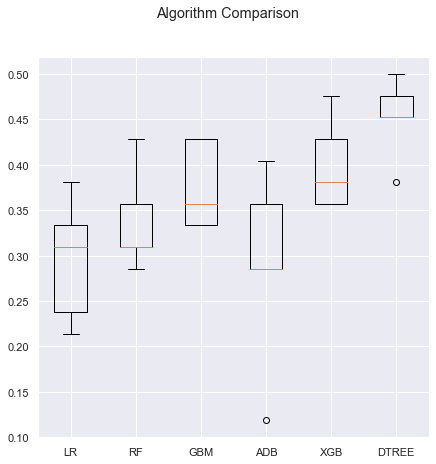

In [46]:
# Plotting boxplots for CV scores of all models defined above
fig = plt.figure()

fig.suptitle("Algorithm Comparison")
ax = fig.add_subplot(111)

plt.boxplot(results)
ax.set_xticklabels(names)

plt.show()

- We can see that decision tree is giving the highest cross validated recall followed by xgboost
- The boxplot shows that the performance of deciion tree is consistent with just one outlier
- We will tune best two models i.e. decision tree and xgboost and see if the performance improves 

# Hyperparameter Tuning
**We will use pipelines with StandardScaler and  AdaBoost model and tune the model using GridSearchCV and RandomizedSearchCV. We will also compare the performance and time taken by these two methods - grid search and randomized search.**

**We can also use make_pipeline function instead of Pipeline to create a pipeline.**

**`make_pipeline`: This is a shorthand for the Pipeline constructor; it does not require, and does not permit, naming the estimators. Instead, their names will be set to the lowercase of their types automatically.**

**Fist let's create two functions to calculate different metrics and confusion matrix, so that we don't have to use the same code repeatedly for each model.**

In [47]:
##  Function to calculate different metric scores of the model - Accuracy, Recall and Precision
def get_metrics_score(model, flag=True):
    """
    model : classifier to predict values of X

    """
    # defining an empty list to store train and test results
    score_list = []

    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    train_acc = model.score(X_train, y_train)
    test_acc = model.score(X_test, y_test)

    train_recall = metrics.recall_score(y_train, pred_train)
    test_recall = metrics.recall_score(y_test, pred_test)

    train_precision = metrics.precision_score(y_train, pred_train)
    test_precision = metrics.precision_score(y_test, pred_test)

    score_list.extend(
        (
            train_acc,
            test_acc,
            train_recall,
            test_recall,
            train_precision,
            test_precision,
        )
    )

    # If the flag is set to True then only the following print statements will be dispayed. The default value is set to True.
    if flag == True:
        print("Accuracy on training set : ", model.score(X_train, y_train))
        print("Accuracy on test set : ", model.score(X_test, y_test))
        print("Recall on training set : ", metrics.recall_score(y_train, pred_train))
        print("Recall on test set : ", metrics.recall_score(y_test, pred_test))
        print(
            "Precision on training set : ", metrics.precision_score(y_train, pred_train)
        )
        print("Precision on test set : ", metrics.precision_score(y_test, pred_test))

    return score_list  # returning the list with train and test scores

In [48]:
## Function to create confusion matrix
def make_confusion_matrix(model, y_actual, labels=[1, 0]):
    """
    model : classifier to predict values of X
    y_actual : ground truth

    """
    y_predict = model.predict(X_test)
    cm = metrics.confusion_matrix(y_actual, y_predict, labels=[0, 1])
    data_cm = pd.DataFrame(
        cm,
        index=[i for i in ["Actual - No", "Actual - Yes"]],
        columns=[i for i in ["Predicted - No", "Predicted - Yes"]],
    )
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten() / np.sum(cm)]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
    labels = np.asarray(labels).reshape(2, 2)
    plt.figure(figsize=(10, 7))
    sns.heatmap(data_cm, annot=labels, fmt="")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")

## Decision Tree

### GridSearchCV

In [49]:
# Creating pipeline
pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    "decisiontreeclassifier__criterion": ['gini','entropy'],
    "decisiontreeclassifier__max_depth": [3, 4, 5, None],
    "decisiontreeclassifier__min_samples_split": [2,4,7,10,15]
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)

print(
    "Best Parameters:{} \nScore: {}".format(grid_cv.best_params_, grid_cv.best_score_)
)

Best Parameters:{'decisiontreeclassifier__criterion': 'gini', 'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__min_samples_split': 4} 
Score: 0.4666666666666666


In [50]:
# Creating new pipeline with best parameters
dtree_tuned1 = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(random_state=1, criterion='gini', max_depth=None, min_samples_split=4),
)

# Fit the model on training data
dtree_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(min_samples_split=4, random_state=1))])

Accuracy on training set :  0.9728571428571429
Accuracy on test set :  0.71
Recall on training set :  0.9428571428571428
Recall on test set :  0.5333333333333333
Precision on training set :  0.9658536585365853
Precision on test set :  0.5161290322580645


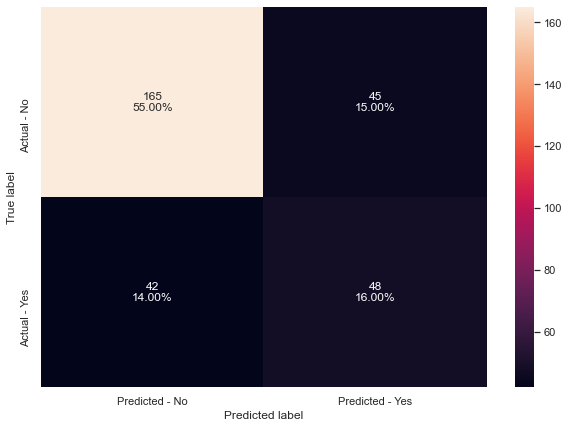

In [51]:
# Calculating different metrics
get_metrics_score(dtree_tuned1)

# Creating confusion matrix
make_confusion_matrix(dtree_tuned1, y_test)

- The test recall has increased by ~8% as compare to cross validated recall
- The tuned decision tree model is overfitting the training data
- The test recall is still just ~53% i.e. the model is not good at identifying defaulters

### RandomizedSearchCV

In [52]:
# Creating pipeline
pipe = make_pipeline(StandardScaler(), DecisionTreeClassifier(random_state=1))

# Parameter grid to pass in GridSearchCV
param_grid = {
    
     "decisiontreeclassifier__criterion": ['gini','entropy'],
    "decisiontreeclassifier__max_depth": [3, 4, 5, None],
    "decisiontreeclassifier__min_samples_split": [2,4,7,10,15]
}
# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=20, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'decisiontreeclassifier__min_samples_split': 7, 'decisiontreeclassifier__max_depth': None, 'decisiontreeclassifier__criterion': 'gini'} with CV score=0.46190476190476193:


In [53]:
# Creating new pipeline with best parameters
dtree_tuned2 = make_pipeline(
    StandardScaler(),
    DecisionTreeClassifier(random_state=1, criterion='gini', max_depth=None, min_samples_split=7),
)

# Fit the model on training data
dtree_tuned2.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(min_samples_split=7, random_state=1))])

Accuracy on training set :  0.94
Accuracy on test set :  0.7066666666666667
Recall on training set :  0.861904761904762
Recall on test set :  0.4888888888888889
Precision on training set :  0.9329896907216495
Precision on test set :  0.5116279069767442


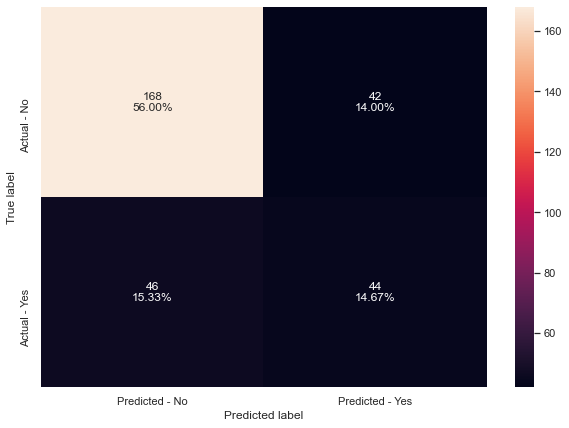

In [54]:
# Calculating different metrics
get_metrics_score(dtree_tuned2)

# Creating confusion matrix
make_confusion_matrix(dtree_tuned2, y_test)

- We reduced the number of iterations to only 20 but two out of the three parameters are same what we got from grid search. 
- The test recall has increased by ~3% as compare to cross validated recall
- The recall and accuracy are slightly less but still similar to the results for decision tree model tuned with GridSearchCV is slightly overfitting the training data

## XGBoost

### GridSearchCV

In [55]:
# Creating pipeline
pipe = make_pipeline(
    StandardScaler(), XGBClassifier(random_state=1, eval_metric="logloss")
)

# Parameter grid to pass in GridSearchCV
param_grid = {
    "xgbclassifier__n_estimators": np.arange(50, 300, 50),
    "xgbclassifier__scale_pos_weight": [0, 1, 2, 5, 10],
    "xgbclassifier__learning_rate": [0.01, 0.1, 0.2, 0.05],
    "xgbclassifier__gamma": [0, 1, 3, 5],
    "xgbclassifier__subsample": [0.7, 0.8, 0.9, 1],
}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

# Calling GridSearchCV
grid_cv = GridSearchCV(estimator=pipe, param_grid=param_grid, scoring=scorer, cv=5)

# Fitting parameters in GridSeachCV
grid_cv.fit(X_train, y_train)


print(
    "Best parameters are {} with CV score={}:".format(
        grid_cv.best_params_, grid_cv.best_score_
    )
)

Best parameters are {'xgbclassifier__gamma': 3, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__n_estimators': 50, 'xgbclassifier__scale_pos_weight': 10, 'xgbclassifier__subsample': 0.9} with CV score=0.8666666666666666:


In [56]:
# Creating new pipeline with best parameters
xgb_tuned1 = make_pipeline(
    StandardScaler(),
    XGBClassifier(
        random_state=1,
        n_estimators=50,
        scale_pos_weight=10,
        subsample=0.9,
        learning_rate=0.01,
        gamma=3,
    ),
)

# Fit the model on training data
xgb_tuned1.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=3, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=50,
                               n_jobs=0, num_parallel_tree=1, random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
                               subsample=0.9, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

Accuracy on training set :  0.5642857142857143
Accuracy on test set :  0.4266666666666667
Recall on training set :  1.0
Recall on test set :  0.8444444444444444
Precision on training set :  0.4077669902912621
Precision on test set :  0.3247863247863248


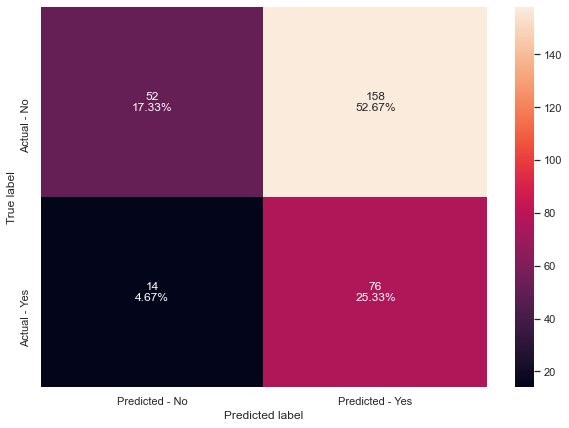

In [57]:
# Calculating different metrics
get_metrics_score(xgb_tuned1)

# Creating confusion matrix
make_confusion_matrix(xgb_tuned1, y_test)

- The test recall has increased by ~44% as compared to the result from cross validation with default parameters.
- The model is overfitting the training data in terms of recall but giving generalized performance in terms of accuracy and precision.
- The model is able to identify most of the defaulters

### RandomizedSearchCV

In [58]:
#Creating pipeline
pipe=make_pipeline(StandardScaler(),XGBClassifier(random_state=1))

#Parameter grid to pass in GridSearchCV
param_grid={'xgbclassifier__n_estimators':np.arange(50,300,50),'xgbclassifier__scale_pos_weight':[0,1,2,5,10],
            'xgbclassifier__learning_rate':[0.01,0.1,0.2,0.05], 'xgbclassifier__gamma':[0,1,3,5],
            'xgbclassifier__subsample':[0.7,0.8,0.9,1]}

# Type of scoring used to compare parameter combinations
scorer = metrics.make_scorer(metrics.recall_score)

#Calling RandomizedSearchCV
randomized_cv = RandomizedSearchCV(estimator=pipe, param_distributions=param_grid, n_iter=50, scoring=scorer, cv=5, random_state=1)

#Fitting parameters in RandomizedSearchCV
randomized_cv.fit(X_train,y_train)

print("Best parameters are {} with CV score={}:" .format(randomized_cv.best_params_,randomized_cv.best_score_))

Best parameters are {'xgbclassifier__subsample': 0.9, 'xgbclassifier__scale_pos_weight': 10, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__learning_rate': 0.01, 'xgbclassifier__gamma': 1} with CV score=0.8238095238095238:


In [59]:
# Creating new pipeline with best parameters
xgb_tuned2 = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "XGB",
            XGBClassifier(
                random_state=1,
                n_estimators=20,
                scale_pos_weight=10,
                learning_rate=0.01,
                gamma=1,
                subsample=0.9,
            ),
        ),
    ]
)
# Fit the model on training data
xgb_tuned2.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('XGB',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=1, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='', learning_rate=0.01,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=20,
                               n_jobs=0, num_parallel_tree=1, random_state=1,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=10,
                               subsample=0.9, tree_method='exact',
                               validate_parameters=1, verbosity=None))])

Accuracy on training set :  0.5471428571428572
Accuracy on test set :  0.4166666666666667
Recall on training set :  1.0
Recall on test set :  0.8444444444444444
Precision on training set :  0.3984819734345351
Precision on test set :  0.3206751054852321


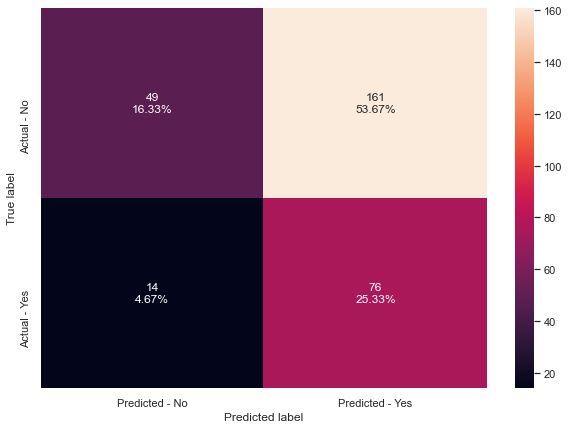

In [60]:
# Calculating different metrics
get_metrics_score(xgb_tuned2)

# Creating confusion matrix
make_confusion_matrix(xgb_tuned2, y_test)

- We reduced the number of iterations to only 20 but the model performance is very similar to the results for xgboost model tuned with GridSearchCV

### Comparing models from GridsearchCV and RandomisedsearchCV

In [61]:
# defining list of models
models = [xgb_tuned1, xgb_tuned2, dtree_tuned1, dtree_tuned2]

# defining empty lists to add train and test results
acc_train = []
acc_test = []
recall_train = []
recall_test = []
precision_train = []
precision_test = []

# looping through all the models to get the metrics score - Accuracy, Recall and Precision
for model in models:

    j = get_metrics_score(model, False)
    acc_train.append(j[0])
    acc_test.append(j[1])
    recall_train.append(j[2])
    recall_test.append(j[3])
    precision_train.append(j[4])
    precision_test.append(j[5])

In [62]:
comparison_frame = pd.DataFrame(
    {
        "Model": [
            "XGBoost tuned with GridSearchCV",
            "XGBoost tuned with RandomizedSearchCV",
            "Decision tree tuned with GridSearchCV",
            "Decision tree tuned with RandomizedSearchCV"
        ],
        "Train_Accuracy": acc_train,
        "Test_Accuracy": acc_test,
        "Train_Recall": recall_train,
        "Test_Recall": recall_test,
        "Train_Precision": precision_train,
        "Test_Precision": precision_test,
    }
)

# Sorting models in decreasing order of test recall
comparison_frame.sort_values(by="Test_Recall", ascending=False)

,Model,Train_Accuracy,Test_Accuracy,Train_Recall,Test_Recall,Train_Precision,Test_Precision
0,XGBoost tuned with GridSearchCV,0.564286,0.426667,1.000000,0.844444,0.407767,0.324786
1,XGBoost tuned with RandomizedSearchCV,0.547143,0.416667,1.000000,0.844444,0.398482,0.320675
2,Decision tree tuned with GridSearchCV,0.972857,0.710000,0.942857,0.533333,0.965854,0.516129
3,Decision tree tuned with RandomizedSearchCV,0.940000,0.706667,0.861905,0.488889,0.932990,0.511628


- We can see that XGBoost is giving similar performance with GridSearchCV and RandomizedSearchCV with test recall of ~0.84
- Let's see the feature importance from the xgboost model tuned with GridSearchCV as it has slightly greater accuracy and precision.

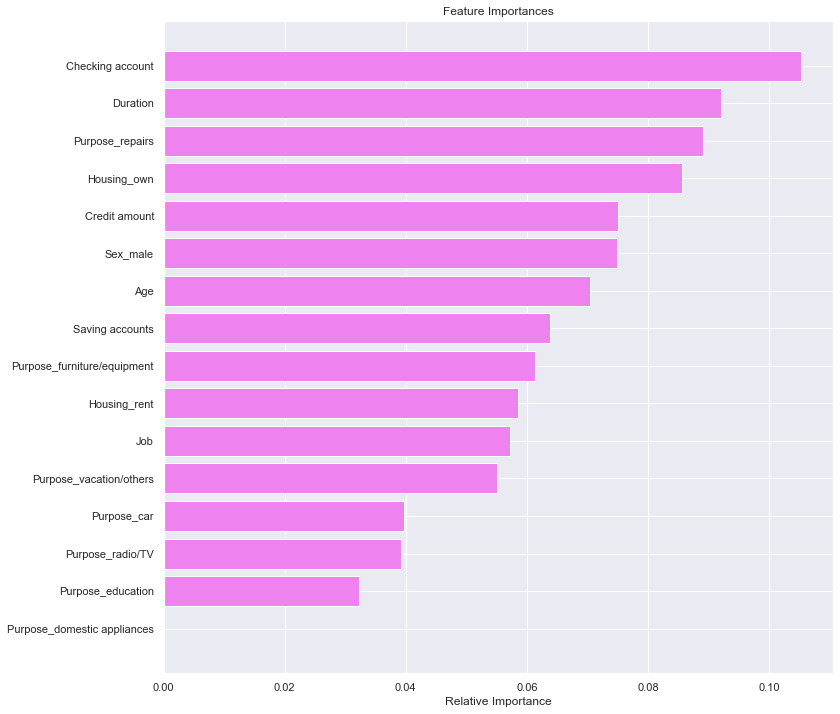

In [63]:
feature_names = X_train.columns
importances = xgb_tuned1[1].feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(12, 12))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color="violet", align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

- Checking account and duration are the two most important variables which makes sense as these variable play an important role in taking/returning credit.

## Conclusion and Insights

- The best test recall in ~84% but the test precision is very low i.e ~32% at the same time. This means that the model is not good at identifying non-defaulter, therefore, bank can lose many opportunities of giving credit to non-defaulters.   
- The model performance can be improved, especially in terms of precision and the bank can use use the model for new customers once desired level of model performance is achieved.
- We saw our analysis that customers with little or moderate amount in saving or checking account are more likely to default. The bank can be more strict with their rules or interest rates to compensate for the risk.
- Customers with high credit amount or who take credit for longer duration are more likely to default. The bank should be more careful while giving high credit amount or for longer duration.
- We saw that customers who have rented or free housing are more likely to default. The bank should keep more details about such customers like hometown address, etc. to be able to track them.
- Our analysis showed that, younger customers are slightly more likely to default. The bank can alter their policies to suppress this.